This notebook peforms a blind tip reconstruction using the gradient decent of the opening from noisy image data

## load required packages and test data

In [148]:
using Flux
using Flux.Data: DataLoader
using Plots
using BSON: @save, @load
using Statistics
using Random
using Revise, MDToolbox

In [149]:
@load "prepare_test_data.bson" width height resolution radius angle param models tip tip_parachuting surfs surfs_parachuting images images_randn

In [150]:
function translate_tip_peak(P)
    tip_xsiz, tip_ysiz = size(P)
    xc, yc = MDToolbox.compute_xc_yc(tip)
    
    p_max, id = findmax(P)
    p_min = minimum(P)

    P_new = deepcopy(P)
    P_new .= p_min - p_max
    
    pxmin = max(1-xc, 1-id[1])
    pymin = max(1-yc, 1-id[2])
    pxmax = min(tip_xsiz-xc, tip_xsiz-id[1])
    pymax = min(tip_ysiz-yc, tip_ysiz-id[2])
    for px = pxmin:pxmax
        for py = pymin:pymax
            P_new[xc+px, yc+py] = P[id[1]+px, id[2]+py] - p_max
        end
    end
    return P_new
end

translate_tip_peak (generic function with 1 method)

In [151]:
function translate_tip_mean(P)
    tip_xsiz, tip_ysiz = size(P)
    xc, yc = MDToolbox.compute_xc_yc(P)

    p_min = minimum(P)
    weight_x = sum(P .- p_min, dims=2)[:]
    if all(weight_x .< 10.0^(-8))
        weight_x .= 1.0
    end
    id_x = round(Int, sum(weight_x .* collect(1.0:1.0:tip_xsiz)) / sum(weight_x))
    weight_y = sum(P .- p_min, dims=1)[:]
    if all(weight_y .< 10.0^(-8))
        weight_y .= 1.0
    end
    id_y = round(Int, sum(weight_y .* collect(1.0:1.0:tip_ysiz)) / sum(weight_y))

    p_max = maximum(P)
    P_new = deepcopy(P)
    P_new .= p_min .- p_max
    
    pxmin = max(1-xc, 1-id_x)
    pymin = max(1-yc, 1-id_y)
    pxmax = min(tip_xsiz-xc, tip_xsiz-id_x)
    pymax = min(tip_ysiz-yc, tip_ysiz-id_y)
    for px = pxmin:pxmax
        for py = pymin:pymax
            P_new[xc+px, yc+py] = P[id_x+px, id_y+py] .- p_max
        end
    end
    return P_new
end

translate_tip_mean (generic function with 1 method)

## Define Flux layers

In [153]:
tip_parachuting

9×9 Matrix{Float64}:
 -1.0e6  -1.0e6  -1.0e6  -1.0e6   -1.0e6   -1.0e6   -1.0e6   -1.0e6   -1.0e6
 -1.0e6  -1.0e6  -1.0e6  -1.0e6   -1.0e6   -1.0e6   -1.0e6   -1.0e6   -1.0e6
 -1.0e6  -1.0e6  -1.0e6  -1.0e6   -1.0e6   -1.0e6   -1.0e6   -1.0e6   -1.0e6
 -1.0e6  -1.0e6  -1.0e6  -0.0    -10.0    -20.0    -30.0    -40.0    -50.0
 -1.0e6  -1.0e6  -1.0e6  -1.0e6   -1.0e6   -1.0e6   -1.0e6   -1.0e6   -1.0e6
 -1.0e6  -1.0e6  -1.0e6  -1.0e6   -1.0e6   -1.0e6   -1.0e6   -1.0e6   -1.0e6
 -1.0e6  -1.0e6  -1.0e6  -1.0e6   -1.0e6   -1.0e6   -1.0e6   -1.0e6   -1.0e6
 -1.0e6  -1.0e6  -1.0e6  -1.0e6   -1.0e6   -1.0e6   -1.0e6   -1.0e6   -1.0e6
 -1.0e6  -1.0e6  -1.0e6  -1.0e6   -1.0e6   -1.0e6   -1.0e6   -1.0e6   -1.0e6

In [154]:
struct IOpen
    P::AbstractArray
end

IOpen(height::Integer, width::Integer) = IOpen(zeros(Float64, height, width))

Flux.@functor IOpen (P,)

(m::IOpen)(image) = idilation(idilation(ierosion(ierosion(image, m.P), tip_parachuting), tip_parachuting), m.P)
#(m::IOpen)(image) = idilation(idilation(ierosion(image, m.P), tip_parachuting), m.P)

## loop over lambda

In [155]:
nrealization = 10
Random.seed!(777);
loss_over_lambdas_array = []
P_over_lambdas_array = []
lambdas = [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1]

for irealization = 1:nrealization
    @info irealization

    for iframe = 1:length(images)
        images_randn[iframe] .= images[iframe] .+ 3.0 .* randn(Float64, size(images[iframe]))
    end
    images_randn_copy = deepcopy(images_randn)

    loss_over_lambdas = []
    P_over_lambdas = []

    for lambda in lambdas
        @info lambda

        m = IOpen(9, 9)

        #loss(image_randn_copy, image_randn) = mean(Flux.Losses.mse.(m.(image_randn_copy), image_randn)) + lambda * sum( -m.P .* log.(-m.P .+ eps(Float32)))
        #loss(image_randn_copy, image_randn) = mean(Flux.Losses.mse.(m.(image_randn_copy), image_randn)) + lambda * sum( - m.P )
        loss(image_randn_copy, image_randn) = mean(Flux.Losses.mse.(m.(image_randn_copy), image_randn))

        ps = Flux.params(m)

        train_loader = Flux.Data.DataLoader((data=images_randn_copy[1:20], label=images_randn[1:20]), batchsize=1, shuffle=false);
        test_loader = Flux.Data.DataLoader((data=images_randn_copy[21:30], label=images_randn[21:30]), batchsize=1);

        #opt = ADAM(1.0)
        opt = ADAMW(1.0, (0.9, 0.999), lambda)
    
        loss_train = []
        loss_test = []

        for epoch in 1:100
            for (x, y) in train_loader
                gs = gradient(() -> loss(x, y), ps)
                Flux.Optimise.update!(opt, ps, gs)
                m.P .= min.(m.P, 0.0)
                #m.P .= translate_tip_peak(m.P)
                m.P .= translate_tip_mean(m.P)
            end
            push!(loss_train, loss(images_randn_copy[1:20], images_randn[1:20]))
            push!(loss_test, loss(images_randn_copy[21:30], images_randn[21:30]))
        end

        push!(loss_over_lambdas, loss_train[end])
        push!(P_over_lambdas, m.P)
    end
    
    push!(loss_over_lambdas_array, loss_over_lambdas)
    push!(P_over_lambdas_array, P_over_lambdas)
end

┌ Info: 1
└ @ Main In[155]:8
┌ Info: 1.0e-6
└ @ Main In[155]:19
┌ Info: 1.0e-5
└ @ Main In[155]:19
┌ Info: 0.0001
└ @ Main In[155]:19
┌ Info: 0.001
└ @ Main In[155]:19
┌ Info: 0.01
└ @ Main In[155]:19
┌ Info: 0.1
└ @ Main In[155]:19
┌ Info: 2
└ @ Main In[155]:8
┌ Info: 1.0e-6
└ @ Main In[155]:19
┌ Info: 1.0e-5
└ @ Main In[155]:19
┌ Info: 0.0001
└ @ Main In[155]:19
┌ Info: 0.001
└ @ Main In[155]:19
┌ Info: 0.01
└ @ Main In[155]:19
┌ Info: 0.1
└ @ Main In[155]:19
┌ Info: 3
└ @ Main In[155]:8
┌ Info: 1.0e-6
└ @ Main In[155]:19
┌ Info: 1.0e-5
└ @ Main In[155]:19
┌ Info: 0.0001
└ @ Main In[155]:19
┌ Info: 0.001
└ @ Main In[155]:19
┌ Info: 0.01
└ @ Main In[155]:19
┌ Info: 0.1
└ @ Main In[155]:19
┌ Info: 4
└ @ Main In[155]:8
┌ Info: 1.0e-6
└ @ Main In[155]:19
┌ Info: 1.0e-5
└ @ Main In[155]:19
┌ Info: 0.0001
└ @ Main In[155]:19
┌ Info: 0.001
└ @ Main In[155]:19
┌ Info: 0.01
└ @ Main In[155]:19
┌ Info: 0.1
└ @ Main In[155]:19
┌ Info: 5
└ @ Main In[155]:8
┌ Info: 1.0e-6
└ @ Main In[155]:19
┌ In

In [156]:
loss_over_lambdas_array[1]

6-element Vector{Any}:
   4.4327487897366105
  11.736707754412844
  13.533254982211858
  22.411053956621636
 129.5443648894674
 250.9461962423498

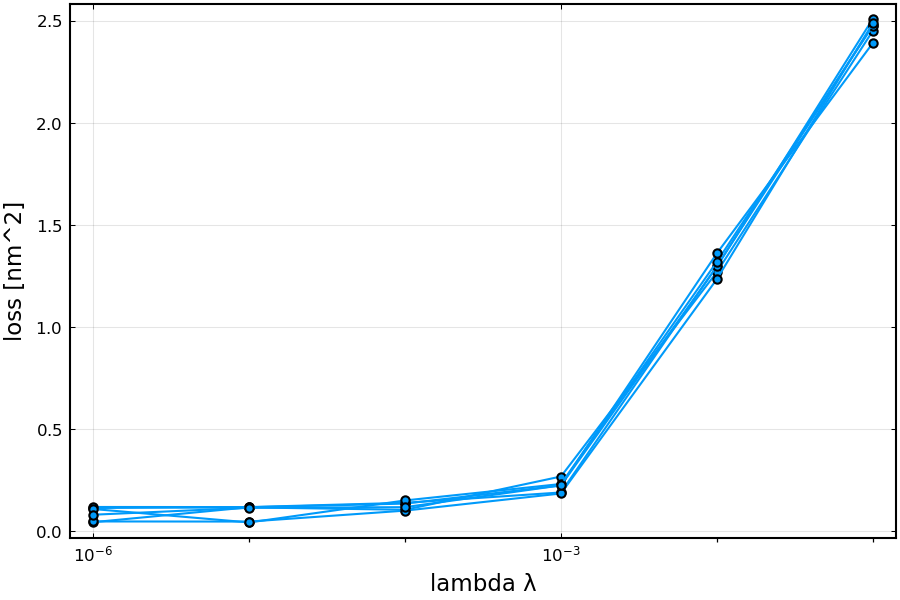

In [157]:
plot(lambdas, loss_over_lambdas_array[1] / 100.0, xaxis=:log, framestyle = :box, xlabel="threshold T", ylabel="loss [nm^2]", label=nothing, linewidth=1.0, markershape=:circle, dpi=150, fmt=:png, color=1)
for i = 2:length(lambdas)
    plot!(lambdas, loss_over_lambdas_array[i] / 100.0, xaxis=:log, framestyle = :box, xlabel="threshold T", ylabel="loss [nm^2]", label=nothing, linewidth=1.0, markershape=:circle, dpi=150, fmt=:png, color=1)
end

xlabel!("lambda λ", fontsize=35)
p = ylabel!("loss [nm^2]", fontsize=35)

In [158]:
savefig(p, "blindtip_opening_randn01.png")

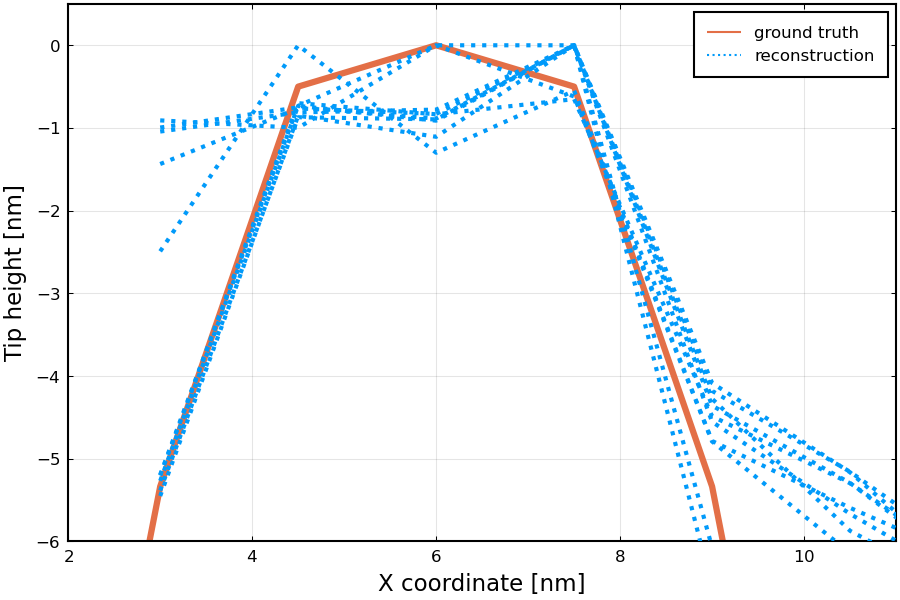

In [163]:
plot(collect(1:9) .* resolution / 10.0, tip[4, :] / 10.0, linewidth=3, label="ground truth", color=2)
for irealization = 1:nrealization
    if irealization == nrealization
        plot!(collect(2:10) .* resolution / 10.0, P_over_lambdas_array[irealization][1][4, 1:end] / 10.0, linewidth=2, linestyle=:dot, color=1, label="reconstruction", framestyle=:box, dpi=150, fmt=:png)
    else
        plot!(collect(2:10) .* resolution / 10.0, P_over_lambdas_array[irealization][1][4, 1:end] / 10.0, linewidth=2, linestyle=:dot, color=1, label=nothing, framestyle=:box, dpi=150, fmt=:png)
    end
end
ylims!((-6, 0.5))
xlims!((2, 11))
xlabel!("X coordinate [nm]", fontsize=35)
p = ylabel!("Tip height [nm]", fontsize=35)

In [164]:
savefig(p, "blindtip_opening_randn02.png")

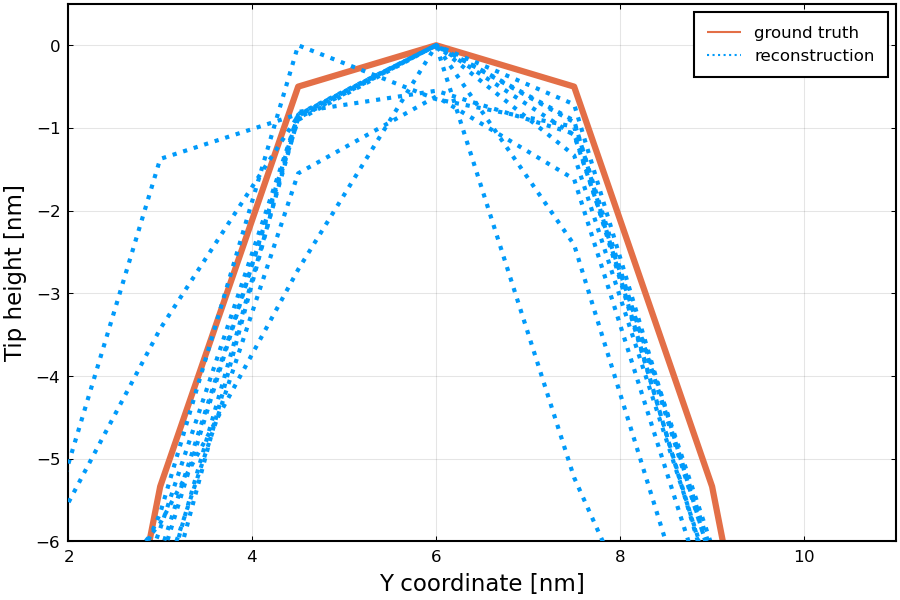

In [166]:
plot(collect(1:9) .* resolution / 10.0, tip[:, 4] / 10.0, linewidth=3, label="ground truth", color=2)
for irealization = 1:nrealization
    if irealization == nrealization
        plot!(collect(1:9) .* resolution / 10.0, P_over_lambdas_array[irealization][1][:, 4] / 10.0, linewidth=2, linestyle=:dot, color=1, label="reconstruction", framestyle=:box, dpi=150, fmt=:png)
    else
        plot!(collect(1:9) .* resolution / 10.0, P_over_lambdas_array[irealization][1][:, 4] / 10.0, linewidth=2, linestyle=:dot, color=1, label=nothing, framestyle=:box, dpi=150, fmt=:png)
    end
end
ylims!((-6, 0.5))
xlims!((2, 11))
xlabel!("Y coordinate [nm]", fontsize=35)
p = ylabel!("Tip height [nm]", fontsize=35)

#plot!(collect(1:9) .* resolution / 10.0, translate_tip_mean(P_over_lambdas_array[4][4])[:, 4] / 10.0, linewidth=5, linestyle=:solid, color=3, label=nothing, framestyle=:box, dpi=150, fmt=:png)

In [167]:
savefig(p, "blindtip_opening_randn03.png")

In [168]:
pyplot()

Plots.PyPlotBackend()

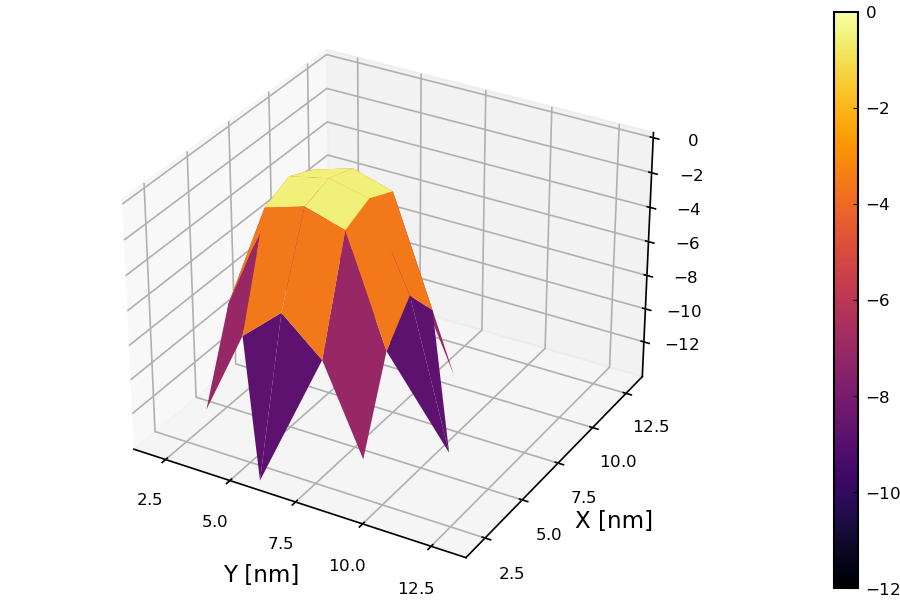

In [169]:
tip_tmp = deepcopy(tip)
tip_tmp[tip .< -150.0] .= NaN

plot(collect(1:9) .* resolution ./ 10.0, collect(1:9) .* resolution ./ 10.0, tip_tmp ./ 10.0, st=:surface, dpi=150, clim=(-12, 0))
xlabel!("Y [nm]", fontsize=35)
p = ylabel!("X [nm]", fontsize=35)
#zlabel!("Z [nm]", fontsize=35)
#zlims!((-8, 0.5))
#zlabel!("Tip height [nm]", fontsize=35)

In [170]:
savefig(p, "blindtip_opening_randn04.png")

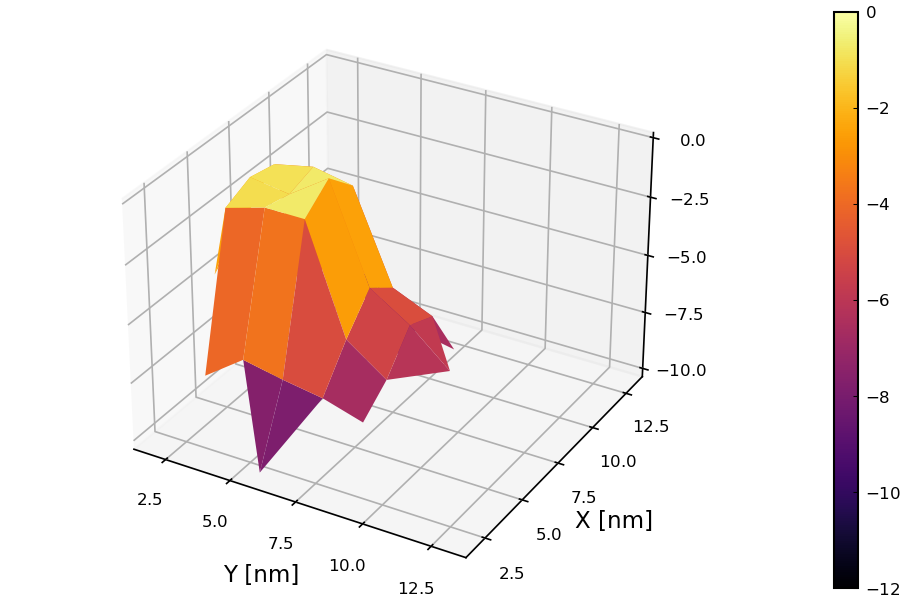

In [171]:
tip_tmp = deepcopy(P_over_lambdas_array[1][1])
tip_tmp[tip .< -150.0] .= NaN

plot(collect(1:9) .* resolution ./ 10.0, collect(1:9) .* resolution ./ 10.0, tip_tmp ./ 10.0, st=:surface, dpi=150, clim=(-12, 0))
xlabel!("Y [nm]", fontsize=35)
p = ylabel!("X [nm]", fontsize=35)
#zlabel!("Z [nm]", fontsize=35)
#zlims!((-8, 0.5))
#zlabel!("Tip height [nm]", fontsize=35)

In [172]:
savefig(p, "blindtip_opening_randn05.png")

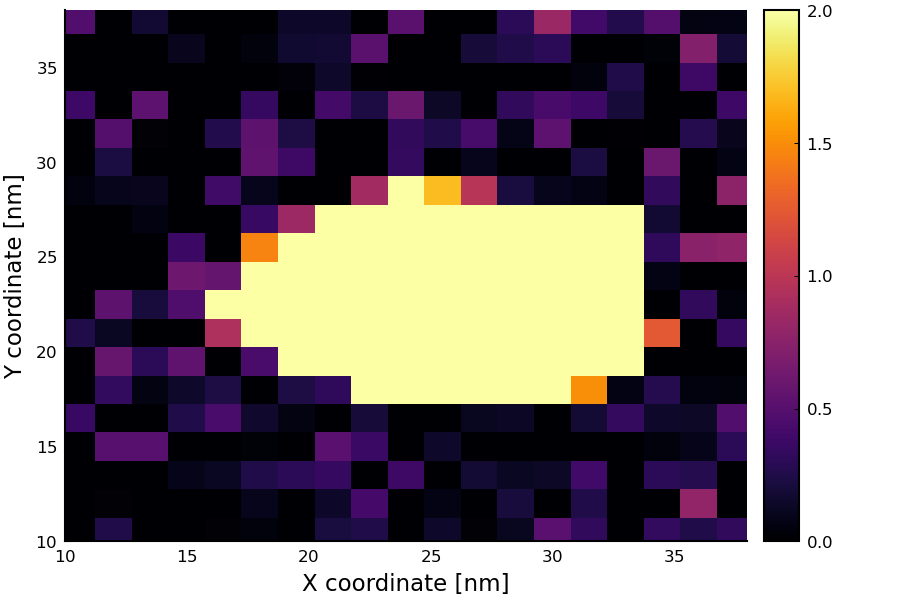

In [173]:
p = heatmap(collect(1:30) .* resolution / 10.0, collect(1:30) .* resolution / 10.0, images_randn[1] / 10.0, clim=(0, 2), dpi=150, fmt=:png)
xlabel!("X coordinate [nm]", fontsize=35)
ylabel!("Y coordinate [nm]", fontsize=35)
xlims!(10, 38)
ylims!(10, 38)

In [174]:
savefig(p, "blindtip_opening_randn06.png")

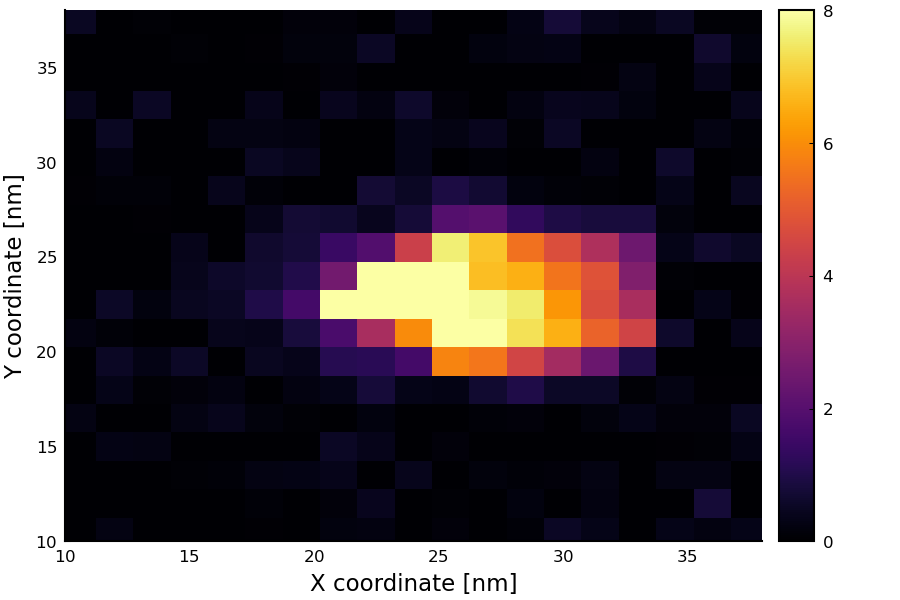

In [175]:
p = heatmap(collect(1:30) .* resolution / 10.0, collect(1:30) .* resolution / 10.0, ierosion(images_randn[1], translate_tip_mean(P_over_lambdas_array[1][1])) / 10.0, clim=(0, 8), dpi=150, fmt=:png)
xlabel!("X coordinate [nm]", fontsize=35)
ylabel!("Y coordinate [nm]", fontsize=35)
xlims!(10, 38)
ylims!(10, 38)

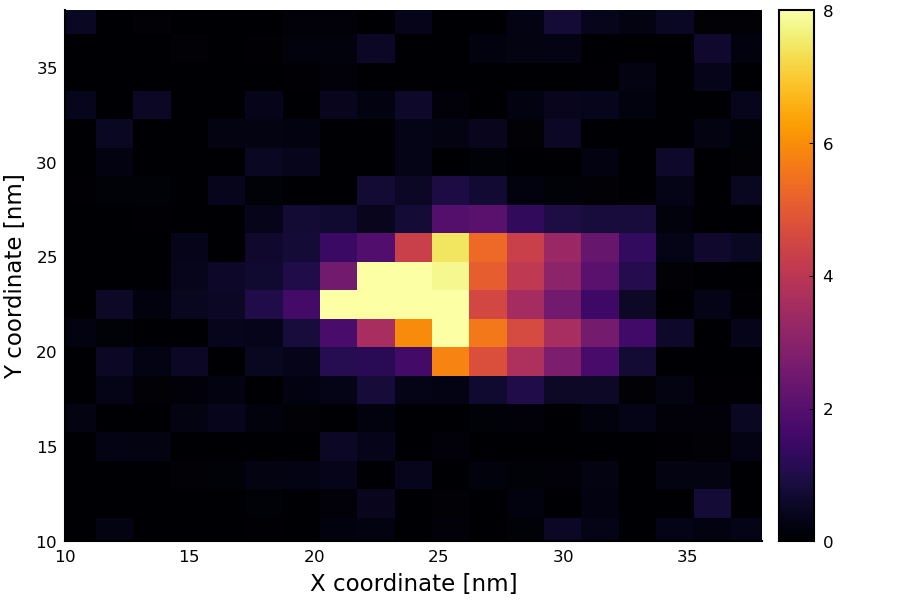

In [182]:
p = heatmap(collect(1:30) .* resolution / 10.0, collect(1:30) .* resolution / 10.0, ierosion(ierosion(images_randn[1], translate_tip_mean(P_over_lambdas_array[1][1])), tip_parachuting) / 10.0, clim=(0, 8), dpi=150, fmt=:png)
xlabel!("X coordinate [nm]", fontsize=35)
ylabel!("Y coordinate [nm]", fontsize=35)
xlims!(10, 38)
ylims!(10, 38)

In [183]:
savefig(p, "blindtip_opening_randn07.png")

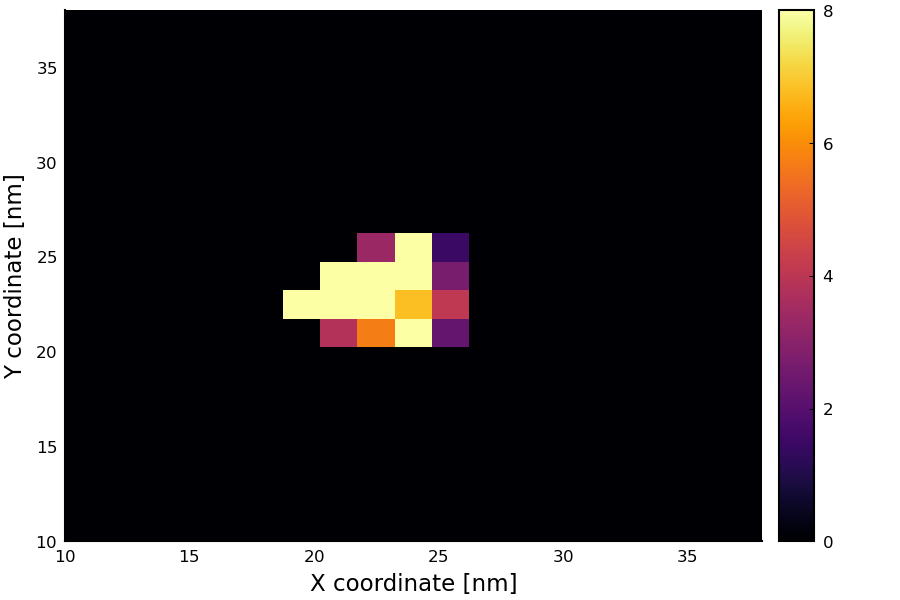

In [184]:
p = heatmap(collect(1:30) .* resolution / 10.0, collect(1:30) .* resolution / 10.0, surfs[1] / 10.0, clim=(0, 8), dpi=150, fmt=:png)
xlabel!("X coordinate [nm]", fontsize=35)
ylabel!("Y coordinate [nm]", fontsize=35)
xlims!(10, 38)
ylims!(10, 38)

In [185]:
savefig(p, "blindtip_opening_randn08.png")